In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rs
import os
from rasterio.plot import show
import glob
import seaborn as sns

import warnings
from scipy import stats
warnings.filterwarnings('ignore', category=FutureWarning)

# First load the files and visualize them

Each file contains three bands, likely corresponding to different wavelengths of light. However, they do not include any metadata or descriptions to explain their contents. Nevertheless, the bands appear to have similar content overall. Additionally, a significant portion of the data is masked by a value of 1. Band 1 is plotted with the mask for reference.

The three data files provided are from the years 2019, 2023, and 2024.


Number of bands in image: 3
Raster description: (None, None, None)
All raster metadata:{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2500, 'height': 1102, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00082122802734375, 0.0, 10.478229224681856,
       0.0, -0.0005560081663499437, 47.73264166394859)}
Metadata for band: {}
Average value: 0.10794660449028015, median: 0.0
min: 0.0,max: 1.0


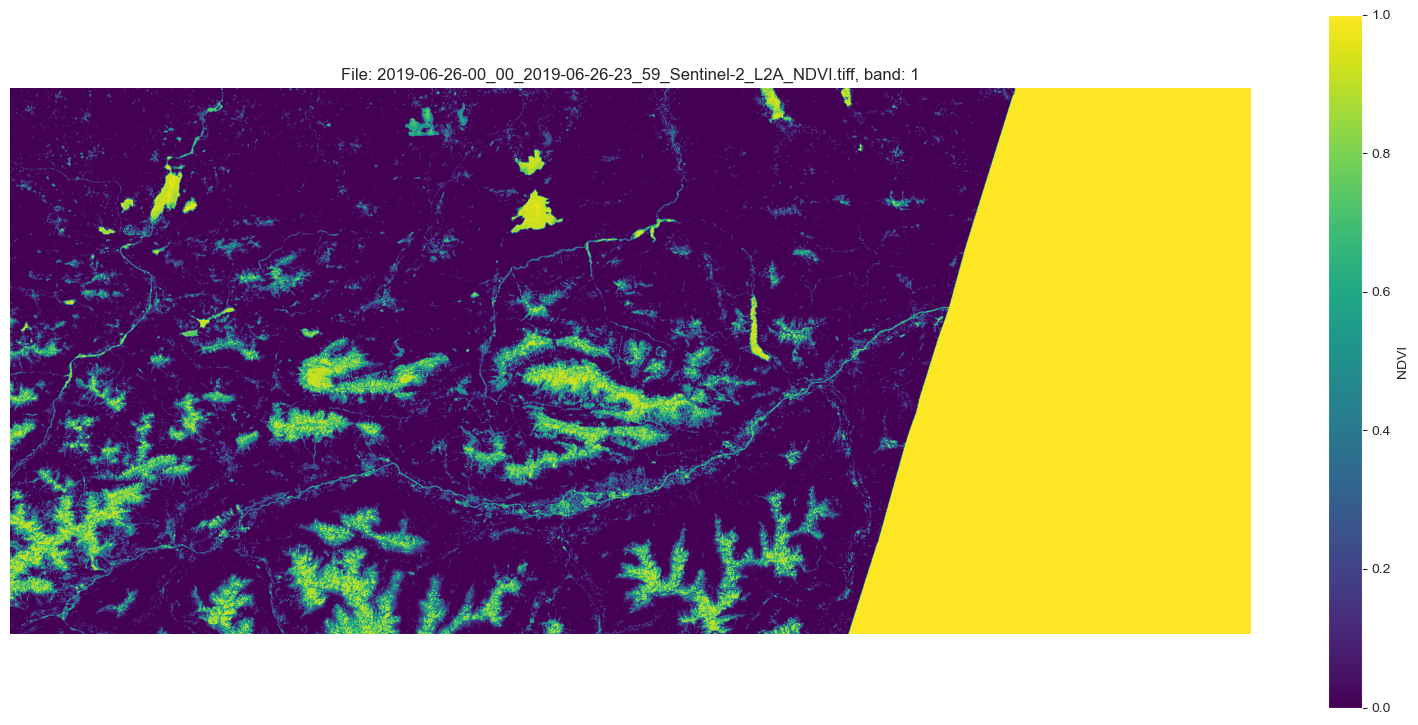

Number of bands in image: 3
Raster description: (None, None, None)
All raster metadata:{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2500, 'height': 1102, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(91.41868582907087, 0.0, 1166431.141706782,
       0.0, -91.48860282046356, 6062490.631553463)}
Metadata for band: {}
Average value: 0.08569605648517609, median: 0.0
min: 0.0,max: 1.0


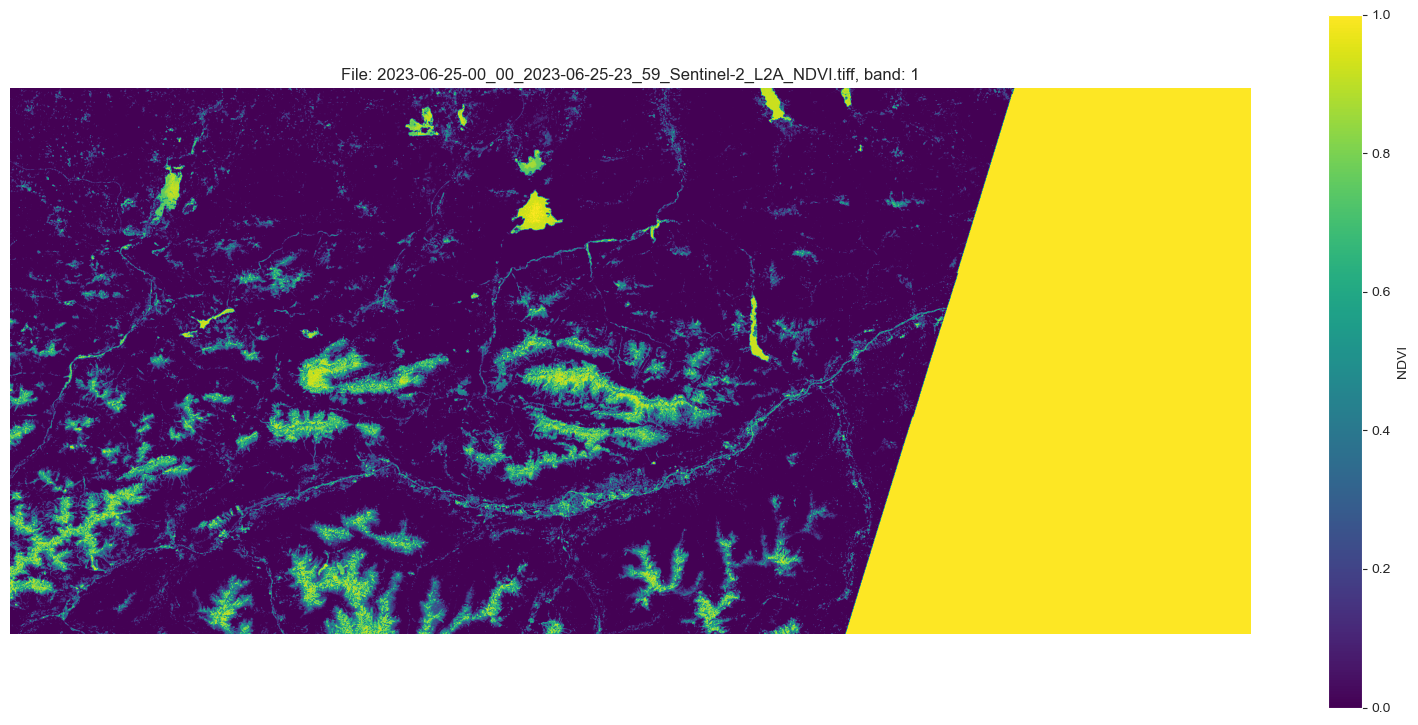

Number of bands in image: 3
Raster description: (None, None, None)
All raster metadata:{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2500, 'height': 1102, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(91.41868582907087, 0.0, 1166431.141706782,
       0.0, -91.48860282046356, 6062490.631553463)}
Metadata for band: {}
Average value: 0.3848961293697357, median: 0.3100000023841858
min: 0.0,max: 1.0


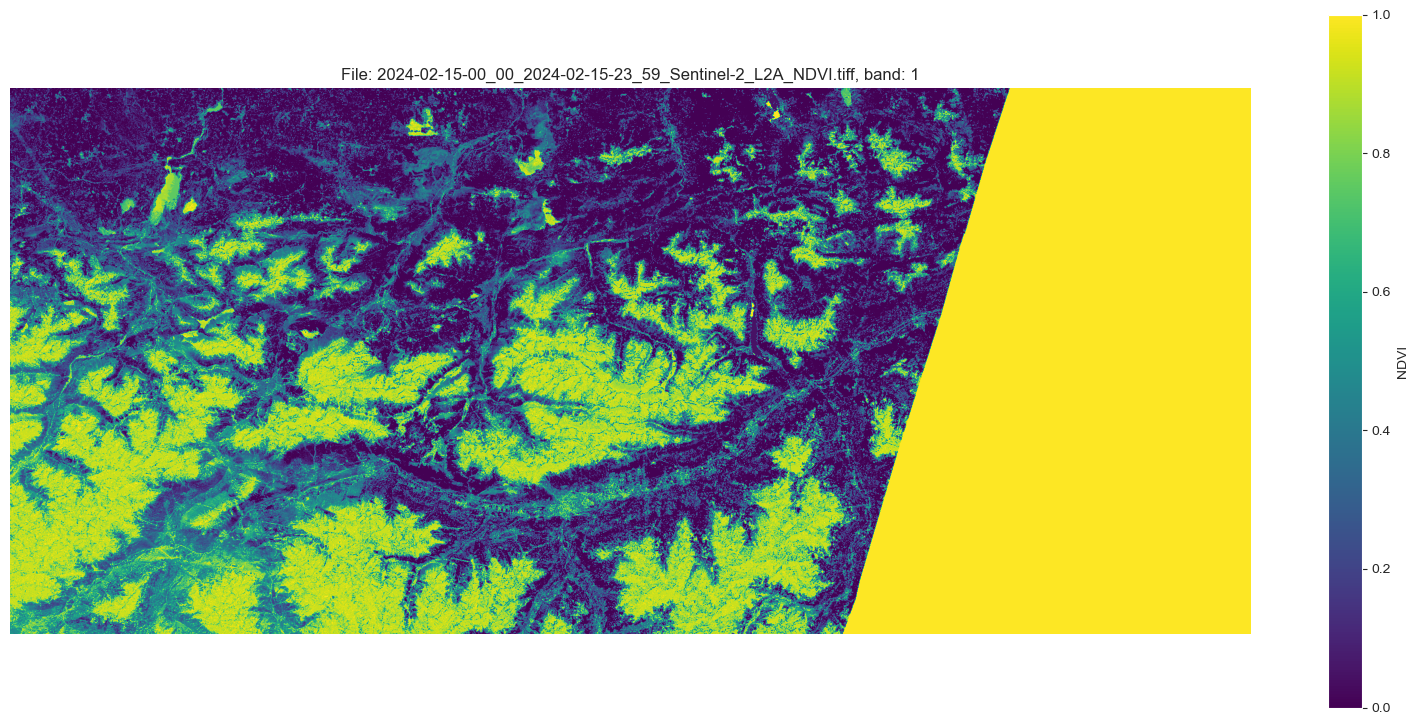

In [2]:
band1 = []
band2 = []
band3 = []

# delete the masked part of the image
def crop_tiff(img):
    inv_img = img[:, ::-1]
    mask = (inv_img != inv_img[0, 0])
    first_different_indices = np.argmax(mask, axis=1)
    for i, idx in enumerate(first_different_indices):
        inv_img[i, :idx] = np.nan
    return inv_img[:, ::-1]


for file in glob.glob('../data/*.tiff'):    
    with rs.open(file) as src:    
        
        # metadata
        print(f'Number of bands in image: {src.count}')       
        print(f'Raster description: {src.descriptions}')           
        print(f'All raster metadata:{src.meta}')
        
        # band 1 basic metrics and plot 
        img = crop_tiff(src.read(1))
        print(f'Metadata for band: {src.tags(1)}')
        print(f'Average value: {np.nanmean(img)}, median: {np.nanmedian(img)}')
        print(f'min: {np.nanmin(img)},max: {np.nanmax(img)}')
        
        plt.figure(figsize=(20, 9))
        plt.axis('off')
        plt.title(f'File: {os.path.basename(file)}, band: 1')
        plt.imshow(src.read(1), cmap='viridis')
        plt.colorbar(label='NDVI')
        plt.show()
        
        # saves each band for later analysis
        band1.append(crop_tiff(src.read(1)))
        band2.append(crop_tiff(src.read(2)))
        band3.append(crop_tiff(src.read(3)))
        
        
        

## Plot the differences and compute basic measures
All the three bands show rather similar characteristics, very slight decrease in year 2023 and large increase in 2024. The Welch's t-test shows that the changes are both statistically significant, however I would not say that the practical difference is significant for the year 2023. Year 2024 shows much bigger difference, The NDVI index is 0.14 to 0.20 larger on average with some areas showing much larger change. From the histogram we can see that change in year in 2023 is almost perfectly gaussian, 2024 change is skewed right to bigger values. That is if we take the data on face value. Note that the files are not exactly aligned, there might be some very small data loss due to that.

In [5]:

def plot_change(band, band_idx):
    b1, b2, b3 = band
    
    # compute change to first year, potential loss of info due to misalignment and np.nan
    delta_1 = (b2 - b1)
    delta_2 = (b3 - b1)
    
    # show changes
    fig, axes = plt.subplots(2, 2, figsize=(18, 8))
    im1 = axes[0,0].imshow(delta_1, cmap='viridis')
    axes[0, 0].set_title(f'Change from 2019 to 2023 for band: {band_idx}')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0])

    im2 = axes[0, 1].imshow(delta_2, cmap='viridis')
    axes[0, 1].set_title(f'Change from 2019 to 2024 for band: {band_idx}')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # compute histograms
    sns.histplot(delta_1[delta_1!=0 ], bins=20, ax=axes[1, 0], stat='density')
    axes[1, 0].set_title(f'Histogram of change from 2019 to 2023 for band: {band_idx}')
    axes[1, 0].set_xlabel(f'Change in NDVI')
    
    sns.histplot(delta_2[delta_2!=0], bins=20, ax=axes[1, 1], stat='density')
    axes[1, 1].set_title(f'Histogram of change from 2019 to 2024 for band: {band_idx}')
    axes[1, 1].set_xlabel(f'Change in NDVI')
    
    #compute metrics for changed values and for all values
    d1_flat = delta_1[delta_1 != 0]
    d1_avg = np.nanmean(d1_flat)
    d1_med = np.nanmedian(d1_flat)
    
    o_d1_flat = delta_1.reshape(-1)
    o_d1_avg = np.nanmean(o_d1_flat)
    o_d1_med = np.nanmedian(o_d1_flat)
    
    o_d2_flat = delta_2.reshape(-1)
    o_d2_avg = np.nanmean(o_d2_flat)
    o_d2_med = np.nanmedian(o_d2_flat)
    
    d2_flat = delta_2[delta_2!=0]
    d2_avg = np.nanmean(d2_flat)
    d2_med = np.nanmedian(d2_flat)    
    
    # [~np.isnan(b1)] used to filter np.nan
    print(f'Average change (Values that have changed) from 2019 to 2023: {d1_avg}, median: {d1_med}')
    print(f'Average overall change (All values) from 2019 to 2023: {o_d1_avg}, median: {o_d1_med}')
    print(f'T-test overall: {stats.ttest_ind(b1[~np.isnan(b1)], b2[~np.isnan(b2)], equal_var=False, nan_policy="omit")}')
    print(f'Average change (Values that have changed) from 2019 to 2024: {d2_avg}, median: {d2_med}')
    print(f'Average overall change (All values) from 2019 to 2024: {o_d2_avg}, median: {o_d2_med}')
    print(f'T-test overall: {stats.ttest_ind(b1[~np.isnan(b1)], b3[~np.isnan(b3)], equal_var=False, nan_policy="omit")}')   
    
    plt.show()
    

Average change (Values that have changed) from 2019 to 2023: -0.082252636551857, median: -0.06000000238418579
Average overall change (All values) from 2019 to 2023: -0.022418014705181122, median: 0.0
T-test overall: TtestResult(statistic=100.25852941623992, pvalue=0.0, df=4024996.3823175277)
Average change (Values that have changed) from 2019 to 2024: 0.39511215686798096, median: 0.3799999952316284
Average overall change (All values) from 2019 to 2024: 0.27639201283454895, median: 0.1899999976158142
T-test overall: TtestResult(statistic=-904.9503292872371, pvalue=0.0, df=3491262.185897522)


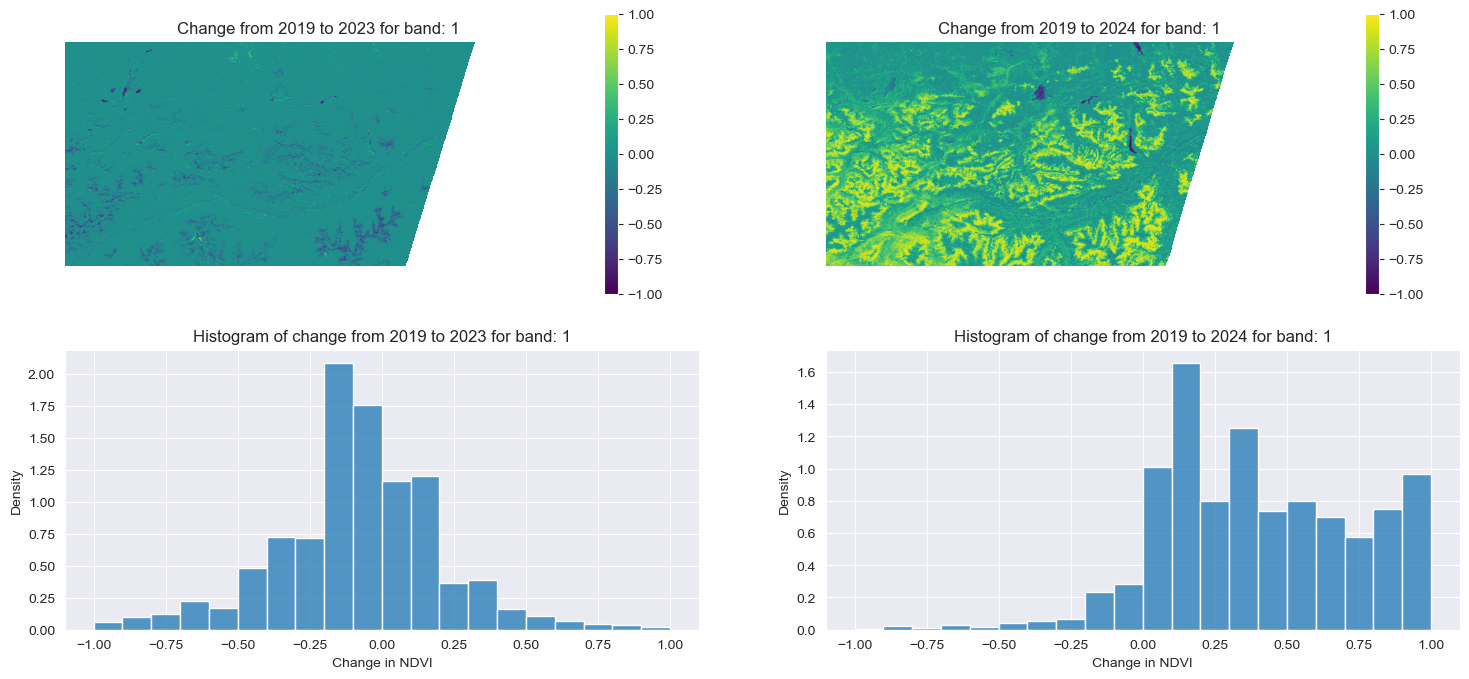

Average change (Values that have changed) from 2019 to 2023: -0.062451958656311035, median: -0.06000000238418579
Average overall change (All values) from 2019 to 2023: -0.01699589006602764, median: 0.0
T-test overall: TtestResult(statistic=103.75908740806567, pvalue=0.0, df=4038381.085879388)
Average change (Values that have changed) from 2019 to 2024: 0.28437915444374084, median: 0.27000001072883606
Average overall change (All values) from 2019 to 2024: 0.19875913858413696, median: 0.15999996662139893
T-test overall: TtestResult(statistic=-916.1624526507377, pvalue=0.0, df=3563105.9074640116)


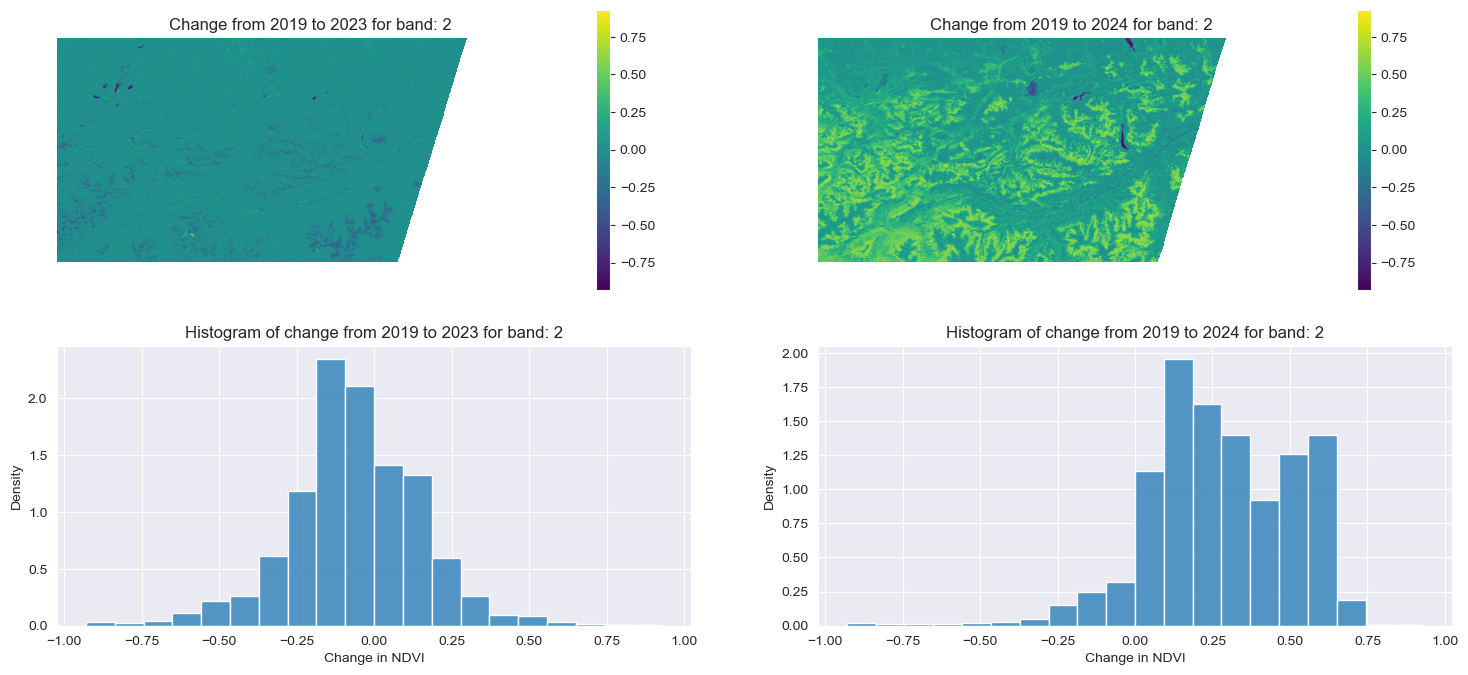

Average change (Values that have changed) from 2019 to 2023: -0.06431793421506882, median: -0.040000006556510925
Average overall change (All values) from 2019 to 2023: -0.017529893666505814, median: 0.0
T-test overall: TtestResult(statistic=99.25016552406188, pvalue=0.0, df=3992664.4929694324)
Average change (Values that have changed) from 2019 to 2024: 0.32065439224243164, median: 0.22999998927116394
Average overall change (All values) from 2019 to 2024: 0.2243068963289261, median: 0.10999999940395355
T-test overall: TtestResult(statistic=-829.8385611775636, pvalue=0.0, df=3216731.183956427)


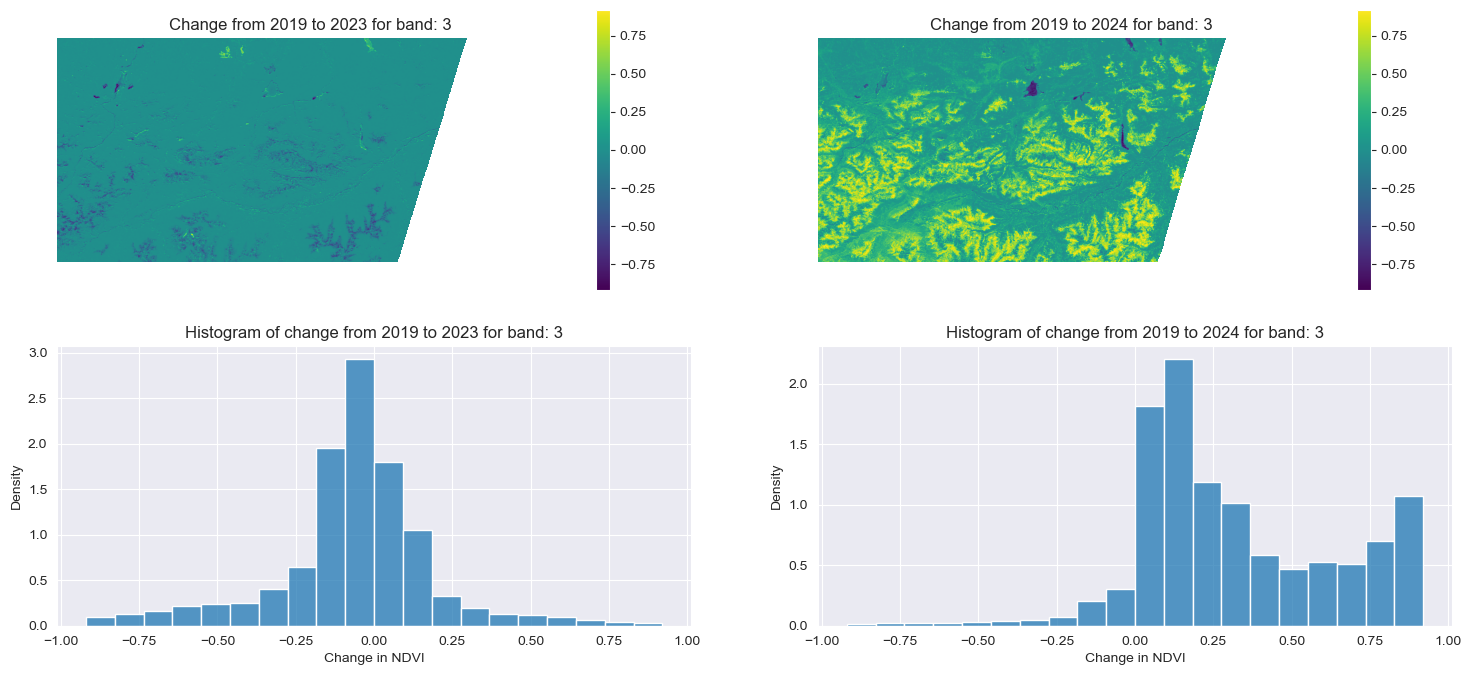

In [6]:
plot_change(band1, 1)
plot_change(band2, 2)
plot_change(band3, 3)


## Interpretation and problems with the data
If we solely interpret the data at face value, it appears that vegetation has slightly but statistically significantly decreased in year 2023 and notably increased in the year 2024, with only a few small areas displaying significant decreases (Water bodies), as observed in the change images. However, several potential issues need consideration:

1. Timing of Data Capture:
The dates of data capture can be deduced from the file names. While the TIFF files from 2019 and 2023 were captured almost on the same dates, namely June 25th and June 26th respectively, the file from 2024 was captured on February 15th. Thus, despite observing a significant change, it's highly likely that other variables are influencing the results, such as the seasonal variation of European climate.
2. The size of the data:
To gain meaningful insight into vegetation changes, a larger amount of data would be necessary, rather than just three samples (even if captured at similar times). We should collect bigger dataset over time (more yearly data and more years), possibly aggregate it, and then compare the results. That would also be better for doing statistical testing. Mainly for pixel to pixel t-test.
3. The sensibility of data:
In temperate regions, it is expected to observe a decrease in vegetation and therefore NDVI in winter; however, we can see the exact opposite. My assumption is that the data may have been altered due to several reasons:
    * Water bodies, mountain peaks, Innsbruck, and other cities in the summer files exhibit high NDVI values.
    * In the winter file, high values are observed where continuous snow cover would typically be expected, such as at the tops of mountain ranges.
    * Typically, NDVI ranges from -1 to 1; however, the provided files range from 0 to 1. There is no information about the rescaling method used to achieve this, and it is highly unlikely to be a result of unaltered data.
4. No info about the 3 bands:
With any information about the NDVI bands, I was unable to gain more info by comparing the difference in between them. Perhaps someone with expertise in remote sensing and NDVI analysis is able to figure that out. Especially if rasterio's function `show()` can make a RGB image from the data.


This leads me to believe that the data was inverted and then rescaled/normalized between 0 and 1 or vice versa. So if we account to that and **invert our findings**, we are still not in position to give any reasonable guess about the long term effect of vegetation change, but we can say (After looking at: https://www.zamg.ac.at/) that the higher NDVI value in 2023 than in 2019 is probably due to more rainfall and other climate effects rather than to some long term effect. 2024 difference can be explained by different time of the year.

## How to improve the analysis:
In addition to the solutions to the problems listed above, including more datasets such as climate data, elevation data (That would probably explain large part of the data) and soil data could definitely improve our analysis. Also, it would make sense to compare the change to some similar area (Control sample) far away from our client site, to really see if the changes are due to some outside variables or not. More knowledge about the emissions would also be helpful.


## "Is the vegetation in Naturpark Karwendel changing (declining or growing) over time?"
YeYes, most probably it is changing, there are most definitely seasonal changes and also yearly change, we can say that on the almost same date the NDVI index was larger in 2023 than in 2019. Just by visual inspection the area near Scharnitz doesn't show significantly larger changes (positive or negative). And from the three datapoints, if we include our assumptions about the data, we are unable to see any possible negative effect.

